In [1]:
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import IPython
from IPython.core.display import HTML
from IPython.display import Image
import IPython.core.display as di
import matplotlib.cm as cm

import matplotlib.patches as mpatches

#Variáveis Globais para Parâmetros
JMETER_LOG_FILE = 'resultado_bt01.jtl'
TRANSATION_CONTROLE = '\WTC\W\s'
THRESHOLD =  1
PERCENTILE95 =95
PERCENTILE90 =90
TOP_LOWEST=5
DadosMapadeCalor={
    'centro': 1,
    'minimo' :0
}
configRampup={
    'MIN_RUMPUP':5,
    'TARGET'    :485,
    'QTD_STEPs' :10
}
configRampup['THREADSPERSTEP'] = configRampup['TARGET']/configRampup['QTD_STEPs']

In [2]:
#Métodos Auxiliares

CONVERTER_FLOATTODATATIME=True
CONVERTER_STRHORAMINUTOTODATATIME=True
CONVERTER_STRTOTODATATIME=True

def convFloatToDataTime(val):
    try:
        datahora = datetime.fromtimestamp(float(val[:-3])).isoformat()
        datahora = re.sub('T', ' ' , datahora)
        return datetime.strptime(datahora[:-3], '%Y-%m-%d %H:%M')
    except:
        CONVERTER_FLOATTODATATIME = False
        return None

def convStringHoraMinutoToDataTime(val):
    try:
        return datetime.strptime(val, '%H:%M')
    except:
        CONVERTER_STRHORAMINUTOTODATATIME = False 
        return None

def convStringToDataTime(val):
    try:
        return datetime.strptime(val[:-3], '%Y/%m/%d %H:%M')
    except:
        CONVERTER_STRTOTODATATIME = False 
        return None
    
def convertDateTime (timeSTP):
    result = None
    if CONVERTER_FLOATTODATATIME:
        result = convFloatToDataTime(timeSTP)
    if (not result) & CONVERTER_STRHORAMINUTOTODATATIME:
        result = convStringHoraMinutoToDataTime(timeSTP)
    if (not result) & CONVERTER_STRTOTODATATIME:
        result = convStringToDataTime(timeSTP)     
        
    return result

def converttosecond(elapsed):
    result = int(elapsed)
    result /= 1000
    return result

def converttoint(val):
    try:
        result = int(val)
    except:
        result = 0
    return result

def percentile(n):
    def _percentile(x):
        return np.percentile(x, n)
    _percentile.__name__ = 'percentile'.format(n)
    return _percentile

def calcTotal(x, y):
    return x + y

def calcTxErro(x, y):
    return (x/y) * 100

def setZero(x):
    return 0

def calcPercentual(val):
    result = (val/soma) * 100
    result = "{:10.3f}".format(result)
    return result

def setThreshold(x):
    return THRESHOLD

COLUMNS = ['timeStamp','elapsed','label','responseCode','responseMessage','threadName','dataType','success', 'allThreads']

#Carregar Arquivos
def readLogWithoutHeader():
    return pd.read_csv(JMETER_LOG_FILE,
                   sep=',',
                   engine='python', 
                   na_values='-', 
                   header=None ,
                   usecols=[0, 1, 2, 3, 4, 5, 6, 7, 12],
                   names=COLUMNS,
                   converters={'timeStamp': convertDateTime,
                               'elapsed': converttosecond,
                               'responseCode': converttoint
                              }
                   )


def readLogWithHeader():
    return pd.read_csv(JMETER_LOG_FILE,
                   sep=',',
                   engine='python', 
                   na_values='-', 
                   header=0 ,
                   usecols=[0, 1, 2, 3, 4, 5, 6, 7, 12],
                   names=COLUMNS,
                   converters={'timeStamp': convertDateTime,
                               'elapsed': converttosecond,
                               'responseCode': converttoint
                              }
                   )

jmeterlog=[]
try:
    jmeterlog = readLogWithoutHeader()
except:
    jmeterlog = readLogWithHeader()

jmeterlog = jmeterlog.set_index('timeStamp')
jmeterlog.head()

,elapsed,label,responseCode,responseMessage,threadName,dataType,success,allThreads
timeStamp,,,,,,,,
2020-11-14 16:22:00,0.208,01.01 - https://homol.eflex.com.br/vivot/#/log...,200,OK,jp@gc - Ultimate Thread Group 1-1,text,True,1
2020-11-14 16:22:00,0.100,01.02 - https://homol.eflex.com.br/gateway/api...,200,OK,jp@gc - Ultimate Thread Group 1-1,text,True,1
2020-11-14 16:22:00,0.216,01.03 - https://homol.eflex.com.br/gateway/api...,200,OK,jp@gc - Ultimate Thread Group 1-1,text,True,1
2020-11-14 16:22:00,0.230,01.04 - https://homol.eflex.com.br/gateway/api...,200,OK,jp@gc - Ultimate Thread Group 1-1,text,True,1
2020-11-14 16:22:00,0.754,01 - Login,200,"Number of samples in transaction : 4, number o...",jp@gc - Ultimate Thread Group 1-1,NaN,True,1


In [5]:
resquestSessao = resquestsucessT.loc[(resquestsucessT['label'].str.contains('9 - login/sign_in') == True )
                                    ]

resquestSessao = resquestSessao.groupby(['timeStamp']).agg({    
                                                                    'label': ['count'],
                                                                    'elapsed': [percentile(PERCENTILE95)]
    })

resquestSessao.columns = ['Qtd Requests', 'P95 Elapsed']
resquestSessao =  resquestSessao.sort_values(by=['Qtd Requests'],ascending=False)
resquestSessao.head()



,Qtd Requests,P95 Elapsed
timeStamp,,
2020-03-21 01:17:00,678,18.47410
2020-03-21 01:00:00,561,0.68600
2020-03-21 01:04:00,560,5.75100
2020-03-21 01:02:00,535,1.05270
2020-03-21 00:58:00,530,0.78845


In [3]:
#DataSets 
#resquestsucessT = jmeterlog.loc[(jmeterlog['responseCode'] < 400) & (jmeterlog['success'] == True)
#                               & (jmeterlog['label'].str.contains(TRANSATION_CONTROLE) == False )]

resquestsucessT = jmeterlog.loc[(jmeterlog['responseCode'] < 400) & (jmeterlog['success'] == True)
                               
                               & (jmeterlog['label'].str.contains('01 - Login') == True )
                               ]


def processDataSetgrpthreads():
    
    dataset = resquestsucessT.groupby(['timeStamp','threadName']).agg({    
                                                                    'label': ['count'],
                                                                    'elapsed': [percentile(PERCENTILE95)]
    })
    dataset = dataset.reset_index()
    dataset = dataset.set_index('timeStamp')
    dataset.columns = ['threadName', 'Requests', 'TempoResposta']
    dataset = dataset.groupby(['timeStamp']).agg({    
                                                'threadName': ['count'],
                                                'Requests': [np.sum],
                                                'TempoResposta': [percentile(PERCENTILE95)],
    })
    return dataset

def processarTxErro():
    grTXerro = jmeterlog.groupby(['timeStamp','success']).agg({    
        'label': ['count']
    })
    grTXerro = grTXerro.reset_index()
    grTXerro = grTXerro.set_index('timeStamp')
    grTXerro.columns = ['Success', 'Resquest']
    grTXerro['Resquest'].fillna(0, inplace=True)
    grTXerro = pd.pivot_table(grTXerro, 
                              index='timeStamp', 
                              columns = 'Success' , 
                              values='Resquest', 
                              aggfunc={'Resquest': ['sum']})
    try:
        grTXerro.columns = ['Error', 'Success']
    except:
        grTXerro.columns = ['Success']
        grTXerro['Error'] =  [setZero(x) for x in grTXerro['Success'].values]
    grTXerro['Error'].fillna(0, inplace=True)
    grTXerro['Total'] = [calcTotal(x, y) for x, y in grTXerro[['Error', 'Success']].values]
    grTXerro['tx Erro'] = [calcTxErro(x, y) for x, y in grTXerro[['Error', 'Total']].values]
    return grTXerro


def splitInSteps(dataset, grTXerro):
    inicio = 0
    fim = configRampup['MIN_RUMPUP'] -1
    step = 1
    threads = configRampup['THREADSPERSTEP']
    dados = {
            'Step': [],
            'Time': [],
            'WorkLoad \(Threads\)':[],
            'Arrivels \(Threads\)':[],
            'Throughput \(Req/min\)':[],
            'TPS':[],
            'Response Time \(Seg\) AVG':[],
            'Response Time \(Seg\) P90':[],
            'Response Time \(Seg\) P95':[],
            'Response Time \(Seg\) MAX':[],
            'Erro Rate \(%\)':[]
    }
    while len(dataset[inicio:fim]) > 0:
        dados['Step'].append(step)
        try:
            dados['Time'].append('\[%s\]-\[%s\]' % (dataset.index[inicio].strftime("%H:%M"), dataset.index[fim].strftime("%H:%M")))
        except:
            last = len(dataset) - 1 
            dados['Time'].append('\[%s\]-\[%s\]' % (dataset.index[inicio].strftime("%H:%M"), dataset.index[last].strftime("%H:%M")))
        
        
        dados['WorkLoad \(Threads\)'].append("{:10.0f}".format(threads))
        
        dados['Arrivels \(Threads\)'].append("{:10.0f}".format(np.sum(dataset['threadName','count'][inicio:fim])))
        
        dados['Throughput \(Req/min\)'].append("{:10.0f}/min".format(np.max(dataset['Requests','sum'][inicio:fim])))
        dados['TPS'].append("{:10.0f}/s".format(np.max(dataset['Requests','sum'][inicio:fim])/60))
        dados['Response Time \(Seg\) AVG'].append("{:10.2f}s".format(np.average(dataset['TempoResposta','percentile'][inicio:fim])))
        
        dados['Response Time \(Seg\) P90'].append("{:10.2f}s".format(np.percentile(dataset['TempoResposta','percentile'][inicio:fim],PERCENTILE90)))
        dados['Response Time \(Seg\) P95'].append("{:10.2f}s".format(np.percentile(dataset['TempoResposta','percentile'][inicio:fim],PERCENTILE95)))
    
        dados['Response Time \(Seg\) MAX'].append("{:10.2f}s".format(np.max(dataset['TempoResposta','percentile'][inicio:fim])))
        dados['Erro Rate \(%\)'].append("{:10.2f}%".format(np.percentile(grTXerro['tx Erro'][inicio:fim],PERCENTILE95)))
        inicio = inicio + configRampup['MIN_RUMPUP']
        fim = fim + configRampup['MIN_RUMPUP']
        step += 1
        threads += configRampup['THREADSPERSTEP']
    return  dados 

def processDataSetComportamentoBateria():
    dataset = resquestsucessT.groupby([resquestsucessT.index]).agg({
        'label': ['count'],
        'elapsed': [percentile(PERCENTILE95)]
    })
    dataset.columns = ['Request', 'Response Time']
    dataset['Threshold'] = [setThreshold(x) for x in dataset['Request'].values]
    return dataset


def processDataSetMapadeCalor():
    dataset = pd.pivot_table(resquestsucessT, 
                              index='label', 
                              columns = 'timeStamp' , 
                              values='elapsed', 
                              aggfunc={'elapsed': [percentile(PERCENTILE95)]})

    dataset.index.names = ['Requests']
    listCollumns = []
    contatador = 0
    while contatador < len(dataset.columns):
        listCollumns.append(dataset.columns.values[contatador][1].strftime("%H:%M"))
        contatador +=1
    dataset.columns = listCollumns
    for col in listCollumns:
        dataset[col].fillna(0, inplace=True)
    return dataset

def processDataSetRequestLowest():
    lowest = resquestsucessT.groupby(['label']).agg({    
        'elapsed': [percentile(PERCENTILE95)]
        })
    lowest.columns = ['Response Time']
    lowest =  lowest.sort_values(by=['Response Time'],ascending=False)
    lowest =  lowest.head(TOP_LOWEST)

    dfLowest = resquestsucessT.loc[(resquestsucessT['label'].isin(lowest.index))]
    dfLowest = dfLowest.groupby([dfLowest.index, 'label']).agg({
        'elapsed': [percentile(PERCENTILE95)],
        'allThreads': ['max']
    })

    dfLowest = dfLowest.reset_index()
    dfLowest = dfLowest.set_index('timeStamp')
    dfLowest.columns = ['Request','Response Time', 'threads']
    dfLowest = pd.pivot_table(dfLowest, 
                              index='timeStamp', 
                              columns = 'Request' , 
                              values=['Response Time','threads'], 
                              aggfunc={'Response Time': [percentile(PERCENTILE95)],
                                       'threads': ['max']
                                      })

    inicio = 0
    fim = configRampup['MIN_RUMPUP'] -1
    step = 1
    dados = {'Hora|Carga': []}
    for coluna in lowest.index:
        dados[coluna]=[]

    while len(dfLowest[inicio:fim]) > 0:
        try:
            dados['Hora|Carga'].append('[%s-%s] | %s Threads' % (dfLowest.index[inicio].strftime("%H:%M"), 
                                                         dfLowest.index[fim].strftime("%H:%M"),
                                                         np.max(dfLowest['threads','max',coluna][inicio:fim])))
        except:
            last = len(dfLowest) - 1 
            dados['Hora|Carga'].append('[%s-%s] | %s Threads' % (dfLowest.index[inicio].strftime("%H:%M"), 
                                                         dfLowest.index[last].strftime("%H:%M"),
                                                         np.max(dfLowest['threads','max',coluna][inicio:fim])))

        for coluna in lowest.index:
            dados[coluna].append(np.max(dfLowest['Response Time','percentile',coluna][inicio:fim]))  
        inicio = inicio + configRampup['MIN_RUMPUP']
        fim = fim + configRampup['MIN_RUMPUP']
        step += 1  

    resultTestLowest =  pd.DataFrame(dados)
    for coluna in lowest.index:
        resultTestLowest[coluna].fillna(0, inplace=True)
    resultTestLowest = resultTestLowest.set_index('Hora|Carga') 
    return resultTestLowest


    
def processDatasetResponseMessageFalha():
    resquestsucessF = jmeterlog.loc[(jmeterlog['responseCode'] > 400) & (jmeterlog['success'] == False)
                               & (jmeterlog['label'].str.contains(TRANSATION_CONTROLE) == False )]
    resquestsucessF = resquestsucessF.groupby(['responseMessage']).agg({'responseCode': ['count']})
    resquestsucessF.columns = ['Qtd. Requests']
    return resquestsucessF

def processDatasetResponseCode():
    gp_erros_al = jmeterlog.groupby(['responseCode']).agg({
        'responseCode': ['count']
    })

    gp_erros_al.columns = ['Qtd Request']
    global soma 
    soma = np.sum(gp_erros_al['Qtd Request'])
    gp_erros_al['% Request'] = [calcPercentual(val) for val in gp_erros_al['Qtd Request'].values]
    return gp_erros_al



# Resultado da Bateria de Teste



### Números por Step de Carga

In [4]:
print('DOC')

grTXerro = processarTxErro()
dataSetgrpthreads =  processDataSetgrpthreads() 
resultTest = pd.DataFrame(splitInSteps(dataSetgrpthreads, grTXerro))
resultTest = resultTest.set_index('Step')

valores = ''
cabecalho = "<th>Step</th>"

aux = 0
while aux<len(resultTest.columns):
    cabecalho = cabecalho + ("<th>%s</th>" % resultTest.columns.values[aux].replace('\\', ''))
    aux +=1
aux = 0
while aux<len(resultTest):
    valores =valores + ("<tr><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td><td colspan=\"1\">%s</td></tr>" 
                        % (resultTest.index.values[aux],
                        resultTest['Time'].values[aux].replace('\\', ''),
                        resultTest['WorkLoad \(Threads\)'].values[aux].replace('\\', ''),
                        resultTest['Arrivels \(Threads\)'].values[aux].replace('\\', ''),
                        resultTest['Throughput \(Req/min\)'].values[aux].replace('\\', ''), 
                        resultTest['TPS'].values[aux].replace('\\', ''),   
                        resultTest['Response Time \(Seg\) AVG'].values[aux].replace('\\', ''),
                        resultTest['Response Time \(Seg\) P90'].values[aux].replace('\\', ''),
                        resultTest['Response Time \(Seg\) P95'].values[aux].replace('\\', ''),
                        resultTest['Response Time \(Seg\) MAX'].values[aux].replace('\\', ''),
                        resultTest['Erro Rate \(%\)'].values[aux].replace('\\', ''),
                          ))
    
   
    aux +=1

display(HTML('''

<head>


</head>


<body>
    <table class="table table-bordered">
  <thead class="thead-dark">
    <tr>
      %s
    </tr>
  </thead>
  <tbody>
       %s
  </tbody>
</table>

    <!-- Optional JavaScript -->
    <!-- jQuery first, then Popper.js, then Bootstrap JS -->
   
   </body>

''' % (cabecalho, valores)
             
             
             
             
           ))



DOC


Step,Time,WorkLoad (Threads),Arrivels (Threads),Throughput (Req/min),TPS,Response Time (Seg) AVG,Response Time (Seg) P90,Response Time (Seg) P95,Response Time (Seg) MAX,Erro Rate (%)
1,[16:22]-[16:26],48,4,5/min,0/s,0.72s,0.82s,0.84s,0.85s,0.00%
2,[16:27]-[16:31],97,40,41/min,1/s,0.91s,0.97s,0.98s,0.99s,0.00%
3,[16:32]-[16:36],146,100,48/min,1/s,1.39s,1.49s,1.50s,1.51s,0.20%
4,[16:37]-[16:41],194,200,56/min,1/s,2.34s,2.72s,2.80s,2.88s,5.30%
5,[16:42]-[16:46],242,312,95/min,2/s,13.49s,25.51s,28.22s,30.93s,5.03%
6,[16:47]-[16:51],291,394,138/min,2/s,10.26s,14.85s,16.27s,17.69s,8.16%
7,[16:52]-[16:56],340,302,129/min,2/s,14.11s,28.67s,30.22s,31.78s,13.33%
8,[16:57]-[17:01],388,371,128/min,2/s,1.17s,1.42s,1.47s,1.53s,13.48%
9,[17:02]-[17:06],436,498,155/min,3/s,1.56s,1.70s,1.72s,1.73s,13.96%
10,[17:07]-[17:11],485,1054,410/min,7/s,53.54s,83.54s,90.69s,97.83s,46.36%


### Comportamento do Teste

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:593: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x00000259812FEFD0> has a label of '_collection0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


Dados Utilizados no Gráfico


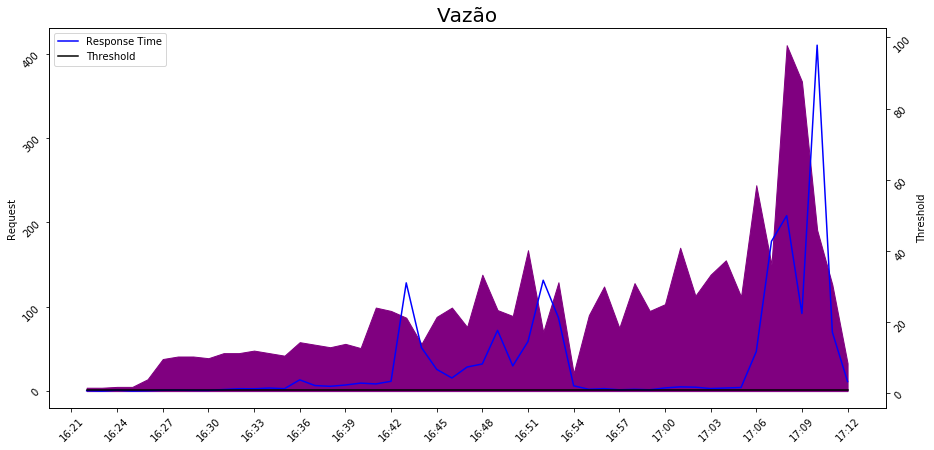

In [4]:
grfcoBateria = processDataSetComportamentoBateria()
    
def gerarGraficoNovo():
    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    grfc1 = ax1.stackplot(grfcoBateria.index, grfcoBateria['Request'], color='purple')
    ax1.set_ylabel("Request")
    ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax1.tick_params(labelrotation=45)
    ax1.xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=3))
    
    ax2 = ax1.twinx() 
    grfc2 = ax2.plot(grfcoBateria.index, grfcoBateria['Response Time'], color='blue')
    ax2.set_ylabel("Response Time")
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax2.tick_params(labelrotation=45)
    ax2.xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=3))
     
    grfc3 = ax2.plot(grfcoBateria.index, grfcoBateria['Threshold'], color='black')
    ax2.set_ylabel("Threshold")
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax2.tick_params(labelrotation=45)
    ax2.xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=3))
    
    # Solution for having two legends
    leg = grfc1 + grfc2 + grfc3
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=2)
    plt.title('Vazão', fontsize=20)
    
gerarGraficoNovo()
print("Dados Utilizados no Gráfico")
#grfcoBateria[['Request','Response Time', 'Threshold']].head(10)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 <a list of 39 Text xticklabel objects>)

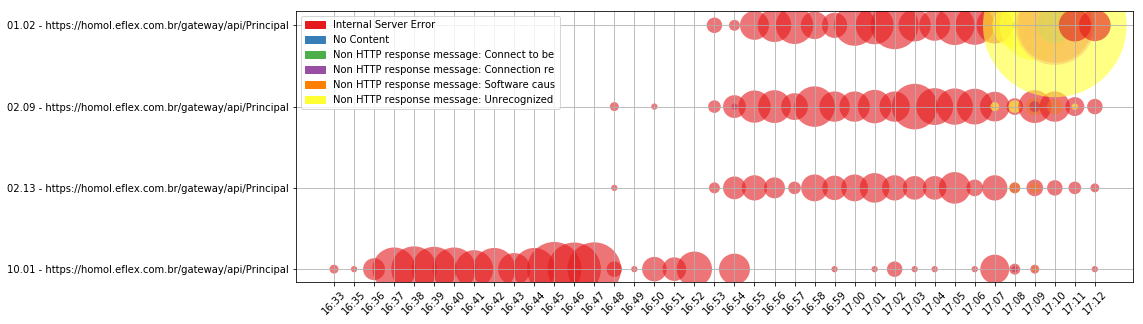

In [54]:
#datasetErro = processDatasetResponseMessageFalha()
listRequestErro = []
datasetGraficoErro = []
datasetLegenda = []
dataframeRqErro = []
lthandles=[]

def getListRequestErro():
    result = jmeterlog.loc[(jmeterlog['responseCode'] > 400) & (jmeterlog['success'] == False)
                               & (jmeterlog['label'].str.contains(TRANSATION_CONTROLE) == False )]
    result = result.groupby(['label']).agg({'label': ['count']})
    global listRequestErro
    listRequestErro =  result.index

def extractHoraMin(val):
    return val.strftime("%H:%M")

def zerarOsOK(msg,qtd):
    result =0
    if not msg == 'OK':
        result = qtd
    return result

def setIdRm(respmsg):
    #print(respmsg)
    global datasetLegenda
    find = datasetLegenda.loc[(datasetLegenda['responseMessage'].str.contains(respmsg[:40]) == True )] 
    return find['IDRM'].values[0]

def setFilterRequest():
    global dataframeRqErro
    dataframeRqErro = jmeterlog.loc[(jmeterlog['label'].str.contains(TRANSATION_CONTROLE) == False )]
    dataframeRqErro = dataframeRqErro.loc[(dataframeRqErro['label'].isin(listRequestErro))]

def prepareDataSetLegenda():
    global datasetLegenda
    datasetLegenda = dataframeRqErro.groupby(['responseMessage']).agg({'label': ['count']})
    datasetLegenda = datasetLegenda.reset_index()
    datasetLegenda.columns = ['responseMessage', 'Qtd']
    datasetLegenda['IDRM'] = list(range(0,  len(datasetLegenda) ))
    datasetLegenda = datasetLegenda.loc[(datasetLegenda['responseMessage'].str.contains('OK') == False )]  
    

def prepareDatasets():
    global datasetGraficoErro
    datasetGraficoErro = dataframeRqErro.groupby(['timeStamp',
                                              'label', 
                                              'responseMessage']).agg({'label': ['count']})

    datasetGraficoErro = datasetGraficoErro.reset_index()
    datasetGraficoErro = datasetGraficoErro.sort_values(by='timeStamp')
    datasetGraficoErro['timeStamp'] =  [extractHoraMin(val) for val in datasetGraficoErro['timeStamp']]
    datasetGraficoErro.columns = ['Hora','Request', 'ResponseMessage', 'Qtd']
    datasetGraficoErro['Qtd'].fillna(0, inplace=True)
    datasetGraficoErro['QTD'] =  [zerarOsOK(msg,qtd) for msg,qtd in datasetGraficoErro[['ResponseMessage','Qtd']].values]
    listareq  = ['10.01 - https://homol.eflex.com.br/gateway/api/Principal',
         '01.02 - https://homol.eflex.com.br/gateway/api/Principal',
         '02.09 - https://homol.eflex.com.br/gateway/api/Principal',
         '02.13 - https://homol.eflex.com.br/gateway/api/Principal']

    datasetGraficoErro = datasetGraficoErro.loc[(datasetGraficoErro['ResponseMessage'].str.contains('OK') == False )
                           & (datasetGraficoErro['Request'].isin(listareq))]
    datasetGraficoErro.drop('Qtd', axis=1, inplace=True)
    datasetGraficoErro['IDRM'] =  [setIdRm(msg) for msg in datasetGraficoErro['ResponseMessage'].values]
    #

    
def buildhandles():
    global lthandles
    cmap = cm.get_cmap('Set1')
    colors = cmap(datasetLegenda['IDRM'].values)
    for x in list(range(0,  len(datasetLegenda) )): #datasetLegenda.index.values:
        red_patch = mpatches.Patch(color=colors[x], label=datasetLegenda['responseMessage'].values[x][:40])
        lthandles.append(red_patch)    
    

    
getListRequestErro()
setFilterRequest()
prepareDataSetLegenda()
buildhandles()
prepareDatasets()

fig, ax = plt.subplots(1,1, figsize=(15,5))
scatter = ax.scatter( datasetGraficoErro['Hora'],    
                      datasetGraficoErro['Request'], 
                      alpha=0.6,
                      c=datasetGraficoErro['IDRM'],
                      edgecolors='none',
                      cmap='Set1',
                      s=40 * datasetGraficoErro['QTD'])
ax.legend(handles=lthandles, loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)


### Mapa de Calor

Dados Utilizados no Gráfico


,16:22,16:23,16:24,16:25,16:26,16:27,16:28,16:29,16:30,16:31,...,17:03,17:04,17:05,17:06,17:07,17:08,17:09,17:10,17:11,17:12
Requests,,,,,,,,,,,,,,,,,,,,,
01 - Login,0.7378,0.62815,0.8548,0.6432,0.73155,0.8616,0.891,0.839,0.827,1.0708,...,1.344,1.4994,1.63935,11.7286,42.72855,49.9175,22.4336,97.825,17.19175,3.3058


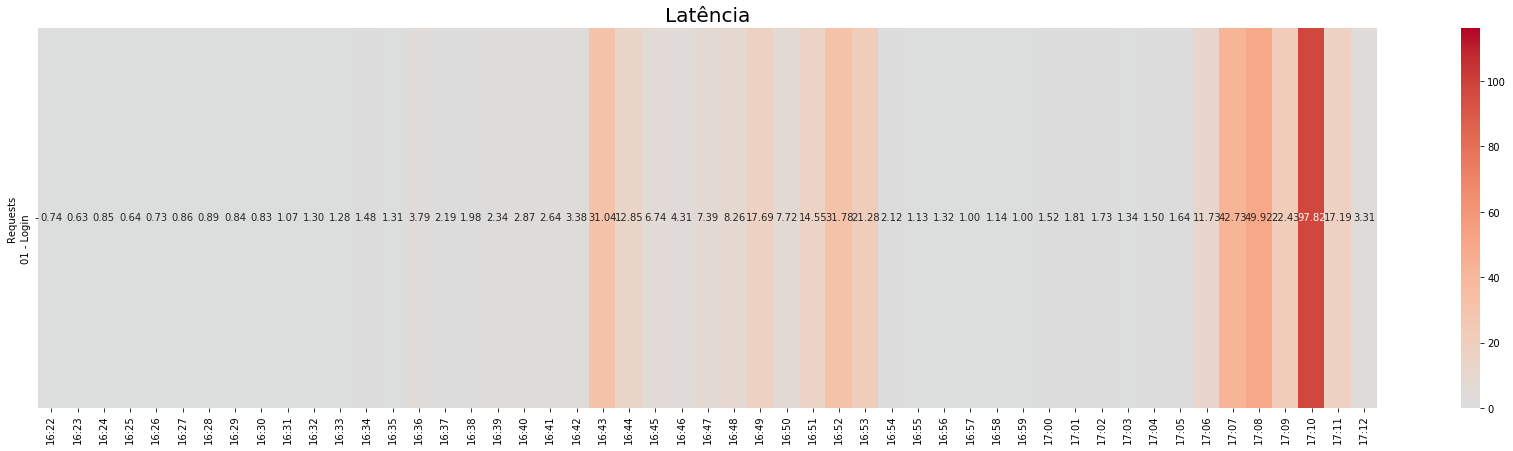

In [8]:
dfmapacalor = processDataSetMapadeCalor() #Dataset panda
responseTimeMax = resquestsucessT['elapsed'].max() #Especificar o maior tempo de Resposta
    
def desenharGraficoInteiro():    
    fig, ax = plt.subplots(figsize=(20,20)) 
    sns.heatmap(dfmapacalor, cmap='coolwarm',annot=True, fmt=".2f", 
            ax=ax, 
            center=DadosMapadeCalor['centro'], 
            vmin=DadosMapadeCalor['minimo'], vmax=responseTimeMax)
    plt.title('Mapa de Calor', fontsize=20)
    
    
def desenharGraficoFracionado():    
    totalgraficos = int("%.0f" % (len(dfmapacalor)/10))
    fig, ax = plt.subplots(totalgraficos,1, figsize=(15,60)) 
    contador = 0
    inicio = 0
    fim  = 10
    while contador<totalgraficos:
        sns.heatmap(dfmapacalor[inicio:fim], cmap='coolwarm',annot=True, fmt=".2f", 
                ax=ax[contador],
                center=DadosMapadeCalor['centro'], 
                vmin=DadosMapadeCalor['minimo'], vmax=responseTimeMax)
        inicio +=10
        contador +=1
        fim +=10
        
def desenharGraficoFracionadoApenas1():    
    totalgraficos = int("%.0f" % (len(dfmapacalor)/10))
    fig, ax = plt.subplots(1,1, figsize=(30,7)) 
    contador = 0
    inicio = 0
    fim  = 10
    sns.heatmap(dfmapacalor[inicio:fim], cmap='coolwarm',annot=True, fmt=".2f", 
            ax=ax,
            center=DadosMapadeCalor['centro'], 
            vmin=DadosMapadeCalor['minimo'], vmax=responseTimeMax)
    inicio +=10
    contador +=1
    fim +=10
    plt.title('Latência', fontsize=20)

#desenharGraficoFracionado()
desenharGraficoFracionadoApenas1()
print("Dados Utilizados no Gráfico")
dfmapacalor.head(5)

Dados Utilizados no Gráfico


,7 - MS1 - 7070,5 - MS1 - 7050,6 - MS1 - 7060,8 - MS1 - 7080,1 - MS1 - 7010
Hora|Carga,,,,,
[15:59-16:01] | 73 Threads,1.74075,1.6850,2.41850,1.93380,1.8165
[16:02-16:04] | 35 Threads,5.20830,5.3392,2.47600,2.02000,13.1311
[16:05-16:07] | 22 Threads,1.93890,2.1242,2.00835,2.05960,1.7330
[16:08-16:10] | 65 Threads,2.49430,2.0656,1.90010,1.98650,1.9864
[16:11-16:13] | 68 Threads,2.20520,1.9560,2.22375,2.19265,1.9525


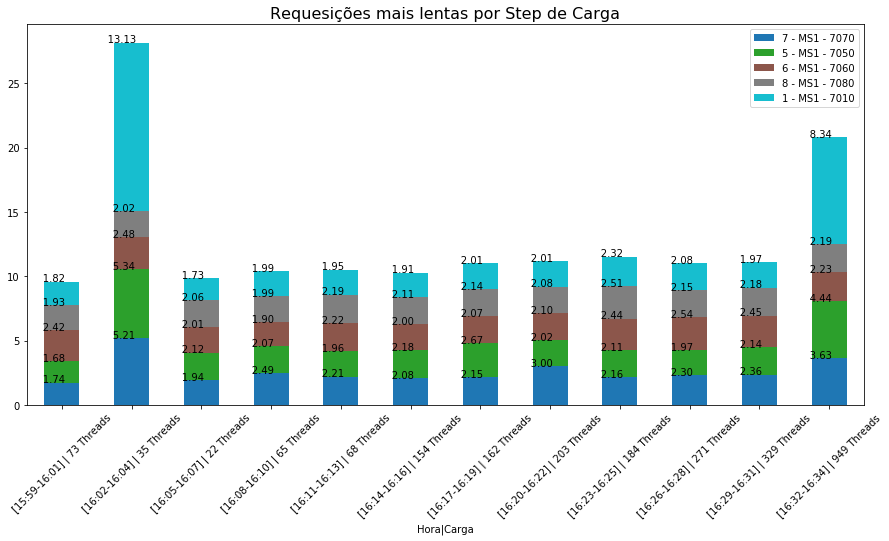

In [26]:
resultTestLowest = processDataSetRequestLowest()  

def buildViewBar(dataset):
    barplot = dataset.plot.bar(figsize=(15, 7), colormap='tab10', stacked=True)
    for p in barplot.patches:
        b = p.get_bbox()
        plt.text(b.x0, b.y1, "{:10.2f}".format(b.y1 - b.y0 )  , ha='center')        
        plt.title('Requesições mais lentas por Step de Carga', fontsize=16)
    plt.xticks(rotation=45)
        
buildViewBar(resultTestLowest)
print("Dados Utilizados no Gráfico")
resultTestLowest.head(5)

In [ ]:
 <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" integrity="sha384-ggOyR0iXCbMQv3Xipma34MD+dH/1fQ784/j6cY/iJTQUOhcWr7x9JvoRxT2MZw1T" crossorigin="anonymous">

    
    <script src="https://code.jquery.com/jquery-3.3.1.slim.min.js" integrity="sha384-q8i/X+965DzO0rT7abK41JStQIAqVgRVzpbzo5smXKp4YfRvH+8abtTE1Pi6jizo" crossorigin="anonymous"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.14.7/umd/popper.min.js" integrity="sha384-UO2eT0CpHqdSJQ6hJty5KVphtPhzWj9WO1clHTMGa3JDZwrnQq4sF86dIHNDz0W1" crossorigin="anonymous"></script>
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/js/bootstrap.min.js" integrity="sha384-JjSmVgyd0p3pXB1rRibZUAYoIIy6OrQ6VrjIEaFf/nJGzIxFDsf4x0xIM+B07jRM" crossorigin="anonymous"></script>
  



In [143]:
# IPython 




#                 Run (once) to allow nice html output as report (optional) 


"""
Hide code cells in an IPython notebook or exported HTML using javascript. 
Taken from Max Masnick's answer in 
http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer.
"""

# Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html(
    '<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area, .output_stderr").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

CSS = """.input_area .output_stderr {height: 2.0em; overflow: hidden}"""  # changes input_subarea width to 1 visible line
HTML('<style>{}</style>'.format(CSS))

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Click in rendered .html output only, toggles the code</button>''', raw=True)

Click in rendered .html output only, toggles the code